Human Activity Recognition using Smartphone Data
Using Hidden Markov Model, classify Human Activity using the smartphone
generated data given by the following dataset:
https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones.
Implement the classification by:
a) Using PCA to compress the data to 100 features.
b) Using the first 100 features of the dataset.
Classify only for the following categories: STANDING, LAYING, SITTING, WALKING.
You can choose values of other hyper parameters as per your choice.

 Get input from accelerometer(can sense rotation for stationary objects)(capacitor-->voltage changes-->force-->acceleration-->displacement(in 3 axis(roll,pitch,yaw)))(integration) and gyroscope(omega-->theta(on integration))(to sense rotation;orientation wrt earth;coriolis force(angular force);capacitor-->rotation-->angle)
 Do filtering (median and butterworth filteers) to remove noise!!
Advantage of integration: cancels out noise(acts as low pass filter)
Jerk is differentiation of acceleration(assuming huge filtration has happened)

# Import the necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,accuracy_score
from sklearn.decomposition import PCA

# Read the train and test files. Convert them to Pandas dataframes

In [2]:
df_train = pd.read_csv('/home/rupeek/Desktop/ML &AI/assns/archive (1)/train.csv')
df_test = pd.read_csv('/home/rupeek/Desktop/ML &AI/assns/archive (1)/test.csv')

In [3]:
df_train.head(5)
#classification label-->acitivity;rest are features

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


# Compute the covariance matrix of the dataset 

In [4]:
data_arr = df_train.iloc[:,0:561].values
cov_data = np.cov(data_arr,rowvar=False)
print(np.linalg.det(cov_data))
#as det=0;means data is linearly dependent hence preprocess(PCA)

0.0


# Data preprocessing before training the classifier 
a) Using PCA to compress the data to 100 features.

In [5]:
pca=PCA(n_components=100)
cov_pca=pca.fit(df_train.iloc[:,0:561].values)

# Data transformation

In [7]:
data_train_pca=cov_pca.transform(df_train.iloc[:,0:561].values)
df_train_red=pd.DataFrame(data_train_pca)

In [8]:
df_train_red['Subject']=df_train['subject']
df_train_red['Activity']=df_train['Activity']


# View the transformed dataset

In [9]:
df_train_red.head()
#100 features with subject and activity

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,Subject,Activity
0,-5.520280,-0.290278,-1.529929,1.333242,1.425089,-0.194708,0.577454,0.691490,-1.222866,-0.363414,...,-0.287033,0.024523,-0.199270,-0.027888,0.000354,0.165676,0.044194,-0.324204,1,STANDING
1,-5.535350,-0.082530,-1.924804,0.671273,0.671260,0.735144,-0.616908,-0.771714,-0.615496,-0.895525,...,-0.082708,0.002337,-0.193039,0.013861,0.084763,0.024223,0.030914,-0.015752,1,STANDING
2,-5.474988,0.287387,-2.144642,0.531806,0.207824,-0.037772,0.057628,0.093917,-0.063147,-0.216898,...,-0.134538,0.021406,-0.256100,-0.138320,-0.115200,-0.034176,0.036598,0.208878,1,STANDING
3,-5.677232,0.897031,-2.018220,0.157125,0.759085,1.079547,-0.267805,-0.731391,0.281296,0.466269,...,0.042520,-0.769279,0.466947,-0.760666,-0.156400,0.075083,-0.491559,-0.273283,1,STANDING
4,-5.748749,1.162952,-2.139533,0.207823,0.473090,0.463035,-0.152227,-0.107509,0.289819,0.539206,...,-0.042317,0.072658,-0.065716,-0.200335,-0.009985,0.184785,-0.104035,0.226873,1,STANDING


# Count the number of datapoints for each posture

b) Using the first 100 features of the dataset.
Classify only for the following categories: STANDING, LAYING, SITTING, WALKING.
You can choose values of other hyper parameters as per your choice.

In [10]:
df_train_red_STAND=df_train_red[df_train_red['Activity']=='STANDING']
df_train_red_SIT=df_train_red[df_train_red['Activity']=='SITTING']
df_train_red_LAY=df_train_red[df_train_red['Activity']=='LAYING']
df_train_red_WALK=df_train_red[df_train_red['Activity']=='WALKING']
df_train_red_WALK_d=df_train_red[df_train_red['Activity']=='WALKING_DOWNSTAIRS']
df_train_red_WALK_u=df_train_red[df_train_red['Activity']=='WALKING_UPSTAIRS']

print(df_train_red_STAND.shape)
print(df_train_red_SIT.shape)
print(df_train_red_LAY.shape)
print(df_train_red_WALK.shape)
print(df_train_red_WALK_d.shape)
print(df_train_red_WALK_u.shape)

(1374, 102)
(1286, 102)
(1407, 102)
(1226, 102)
(986, 102)
(1073, 102)


# Transform test data

In [11]:
df_test.dropna(inplace=True)
#reducing dimensions on test data

In [12]:
data_test_red=cov_pca.transform(df_test.iloc[:,0:561].values)
df_test_red=pd.DataFrame(data_test_red)

In [13]:
df_test_red['Subject']=df_test['subject']
df_test_red['Activity']=df_test['Activity']
df_test_red.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,Subject,Activity
0,-2.686743,-1.216821,-0.722075,-0.117271,-0.546360,0.442701,-0.387679,0.327529,0.117682,-1.593977,...,-0.130706,0.048295,0.122166,0.133705,0.218883,0.084910,0.094334,0.407205,2,STANDING
1,-4.331255,-0.766327,-1.128404,-0.152942,-0.505817,0.485306,-0.423214,0.805947,0.591644,-0.986363,...,-0.112066,0.022329,0.065681,0.180559,0.049666,-0.066283,-0.103062,-0.060725,2,STANDING
2,-4.985360,0.371301,-1.656858,-0.235971,-0.102938,-0.113283,-0.143993,0.279862,0.330125,-0.163722,...,-0.147702,0.198484,0.229465,0.211305,0.036055,-0.160796,0.023610,0.015559,2,STANDING
3,-5.099876,0.243743,-1.802703,0.263715,-0.050454,-0.794957,0.083771,0.650500,0.270365,0.321617,...,-0.014737,0.200747,0.119473,0.078346,0.086969,-0.043615,0.149689,0.018948,2,STANDING
4,-5.023000,-0.518739,-1.871078,0.106466,0.153655,-0.947262,0.668394,0.792005,0.932680,0.593944,...,-0.026053,-0.123437,0.049962,-0.074411,-0.027393,-0.059093,0.003724,0.006494,2,STANDING


In [14]:
df_test_red.shape

(2947, 102)

In [15]:
#calculating true labels
labels_true=[]
for i in range(len(df_test_red)):
    if (df_test_red['Activity'].iloc[i]=='STANDING'):
        labels_true.append(0)#assign no. to labels so that models understand
    if (df_test_red['Activity'].iloc[i]=='SITTING'):
        labels_true.append(1)
    if (df_test_red['Activity'].iloc[i]=='LAYING'):
        labels_true.append(2)   
    if (df_test_red['Activity'].iloc[i]=='WALKING'):
        labels_true.append(3) 
    if (df_test_red['Activity'].iloc[i]=='WALKING_UPSTAIRS'):
        labels_true.append(4) 
    if (df_test_red['Activity'].iloc[i]=='WALKING_DOWNSTAIRS'):
        labels_true.append(5) 
labels_true=np.array(labels_true)           
labels_true.shape

(2947,)

In [17]:
!pip install hmmlearn

     |████████████████████████████████| 362 kB 778 kB/s eta 0:00:01


In [18]:
from hmmlearn import hmm#gmmhmm,gausianhmm,multinomialhmm(here gmmhmm)

In [19]:
#implementing hmm
#since there are 6 activity so fitting hmm for each activity
def HMM_F1score(N,M,labels_true):#(hidden states=N,no. of mixture comp for gmm=M)
    hmm_stand=hmm.GMMHMM(n_components=N,n_mix=M,covariance_type='diag')#diag-->for certain data matrix cov matrix arent square,hence forcefully make off diagonal elements as 0
    hmm_sit=hmm.GMMHMM(n_components=N,n_mix=M,covariance_type='diag')
    hmm_lay=hmm.GMMHMM(n_components=N,n_mix=M,covariance_type='diag')
    hmm_walk=hmm.GMMHMM(n_components=N,n_mix=M,covariance_type='diag')
    hmm_walk_d=hmm.GMMHMM(n_components=N,n_mix=M,covariance_type='diag')
    hmm_walk_u=hmm.GMMHMM(n_components=N,n_mix=M,covariance_type='diag')

    hmm_stand.fit(df_train_red_STAND.iloc[:,0:100].values)
    hmm_sit.fit(df_train_red_SIT.iloc[:,0:100].values)
    hmm_lay.fit(df_train_red_LAY.iloc[:,0:100].values)
    hmm_walk.fit(df_train_red_WALK.iloc[:,0:100].values)
    hmm_walk_d.fit(df_train_red_WALK_d.iloc[:,0:100].values)
    hmm_walk_u.fit(df_train_red_WALK_u.iloc[:,0:100].values)

   #calculating F1 score
    labels_predict = []
    for i in range(len(df_test_red)):
        log_likelihood_value = np.array([hmm_stand.score(df_test_red.iloc[i,0:100].values.reshape((1,100))),hmm_sit.score(df_test_red.iloc[i,0:100].values.reshape((1,100))),hmm_lay.score(df_test_red.iloc[i,0:100].values.reshape((1,100))),hmm_walk.score(df_test_red.iloc[i,0:100].values.reshape((1,100))),hmm_walk_d.score(df_test_red.iloc[i,0:100].values.reshape((1,100))),hmm_walk_u.score(df_test_red.iloc[i,0:100].values.reshape((1,100)))])
        labels_predict.append(np.argmax(log_likelihood_value))   #taking the best probable hmm value by computing log liklihood 
    labels_predict = np.array(labels_predict)  

    F1 = f1_score(labels_true,labels_predict,average='micro')
    acc = accuracy_score(labels_true,labels_predict)
    return F1,acc

In [20]:
states=np.arange(1,36,1)
states

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35])

HMM has been trained for num_states= 1
HMM has been trained for num_states= 2
HMM has been trained for num_states= 3
HMM has been trained for num_states= 4
HMM has been trained for num_states= 5
HMM has been trained for num_states= 6
HMM has been trained for num_states= 7
HMM has been trained for num_states= 8
HMM has been trained for num_states= 9
HMM has been trained for num_states= 10
HMM has been trained for num_states= 11
HMM has been trained for num_states= 12
HMM has been trained for num_states= 13
HMM has been trained for num_states= 14
HMM has been trained for num_states= 15
HMM has been trained for num_states= 16
HMM has been trained for num_states= 17
HMM has been trained for num_states= 18
HMM has been trained for num_states= 19
HMM has been trained for num_states= 20
HMM has been trained for num_states= 21
HMM has been trained for num_states= 22
HMM has been trained for num_states= 23
HMM has been trained for num_states= 24
HMM has been trained for num_states= 25
HMM has b

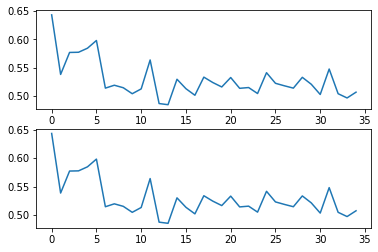

In [21]:
F1_value_states = []
acc_value_states = []
for i in states:
    print("HMM has been trained for num_states= {}".format(i))
    f1,acc = HMM_F1score(i,1,labels_true)
    F1_value_states.append(f1)
    acc_value_states.append(acc)
fig,ax = plt.subplots(2,1)

ax[0].plot(F1_value_states)
ax[1].plot(acc_value_states)

plt.show()
#keep the mixture components fixed and vary hidden states(n vic versa)

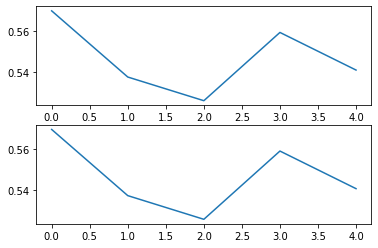

In [22]:
f_test = []
acc_test = []

for i in range(1,6):
    f1,acc1 = HMM_F1score(3,i,labels_true)
    f_test.append(f1)
    acc_test.append(acc1)
    
fig,ax = plt.subplots(2,1)

ax[0].plot(f_test)
ax[1].plot(acc_test)

plt.show()

In [60]:
f1_val,acc_val = HMM_F1score(3,8,labels_true)
print(f1_val)
print(acc_val)

0.5300305395317272
0.5300305395317272


in sequential classificcation data addtional feature compared to normal data is temporal relation(relation btw t and t+1 like a_ij does it). hence HMM is better for handwriting recognition